In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("GOOG.csv", index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897
2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276
...,...,...,...,...,...,...
2021-10-04,2713.989990,2714.000000,2623.330078,2675.300049,2675.300049,1576500
2021-10-05,2680.000000,2747.239990,2680.000000,2723.540039,2723.540039,1206300
2021-10-06,2692.510010,2757.040039,2689.729980,2747.080078,2747.080078,988200


In [3]:
dataset = df['Open']
dataset = dataset.values.astype('float32')
tf.random.set_seed(10)

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
dataset = dataset.reshape(-1,1)
mm = MinMaxScaler(feature_range=(0,1))

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [6]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [7]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [8]:
X_train = mm.fit_transform(X_train)
y_train = mm.fit_transform(y_train)

X_test = mm.transform(X_test)
y_test = mm.transform(y_test)

In [9]:
# reshape input to be (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [11]:
model = Sequential()
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50, input_shape=(1, look_back), return_sequences=True)))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs=100, batch_size = 64, verbose = 2)

Epoch 1/100
54/54 - 6s - loss: 0.0533 - 6s/epoch - 104ms/step
Epoch 2/100
54/54 - 0s - loss: 0.0054 - 150ms/epoch - 3ms/step
Epoch 3/100
54/54 - 0s - loss: 0.0012 - 142ms/epoch - 3ms/step
Epoch 4/100
54/54 - 0s - loss: 0.0011 - 148ms/epoch - 3ms/step
Epoch 5/100
54/54 - 0s - loss: 9.9863e-04 - 140ms/epoch - 3ms/step
Epoch 6/100
54/54 - 0s - loss: 9.3413e-04 - 140ms/epoch - 3ms/step
Epoch 7/100
54/54 - 0s - loss: 9.1993e-04 - 140ms/epoch - 3ms/step
Epoch 8/100
54/54 - 0s - loss: 8.9144e-04 - 140ms/epoch - 3ms/step
Epoch 9/100
54/54 - 0s - loss: 7.8926e-04 - 140ms/epoch - 3ms/step
Epoch 10/100
54/54 - 0s - loss: 7.3580e-04 - 140ms/epoch - 3ms/step
Epoch 11/100
54/54 - 0s - loss: 7.5368e-04 - 140ms/epoch - 3ms/step
Epoch 12/100
54/54 - 0s - loss: 7.3390e-04 - 141ms/epoch - 3ms/step
Epoch 13/100
54/54 - 0s - loss: 6.7500e-04 - 139ms/epoch - 3ms/step
Epoch 14/100
54/54 - 0s - loss: 6.8760e-04 - 140ms/epoch - 3ms/step
Epoch 15/100
54/54 - 0s - loss: 5.9594e-04 - 146ms/epoch - 3ms/step
Epoch 

In [12]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform(y_train)

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform(y_test)

train_score = np.sqrt(mean_squared_error(y_train[:,0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[:,0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

27/27 [==============================] - 0s 939us/step
Train score: 11.85 RMSE
Test score: 136.67 RMSE


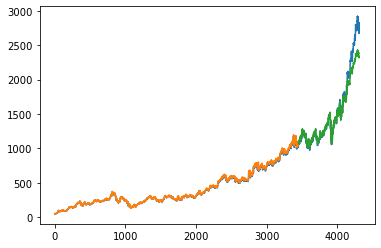

In [13]:
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2):len(dataset)-2, :] = test_pred

plt.plot(dataset)
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Increasing timesteps

In [15]:
df = pd.read_csv("GOOG.csv", index_col='Date', parse_dates=True)
dataset = df['Open']
dataset = dataset.values.astype('float32')
tf.random.set_seed(10)

In [16]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
dataset = dataset.reshape(-1,1)
mm = MinMaxScaler(feature_range=(0,1))

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [18]:
train = mm.fit_transform(train)
test = mm.transform(test)

In [19]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [41]:
X_train.shape

(3448, 3)

In [20]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [22]:
model = Sequential()
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50, input_shape=(1, look_back), return_sequences=True)))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs=100, batch_size = 64, verbose = 2)

Epoch 1/100
54/54 - 5s - loss: 0.0448 - 5s/epoch - 99ms/step
Epoch 2/100
54/54 - 0s - loss: 0.0025 - 140ms/epoch - 3ms/step
Epoch 3/100
54/54 - 0s - loss: 0.0013 - 142ms/epoch - 3ms/step
Epoch 4/100
54/54 - 0s - loss: 0.0011 - 146ms/epoch - 3ms/step
Epoch 5/100
54/54 - 0s - loss: 0.0011 - 154ms/epoch - 3ms/step
Epoch 6/100
54/54 - 0s - loss: 0.0011 - 160ms/epoch - 3ms/step
Epoch 7/100
54/54 - 0s - loss: 9.5845e-04 - 150ms/epoch - 3ms/step
Epoch 8/100
54/54 - 0s - loss: 8.3878e-04 - 160ms/epoch - 3ms/step
Epoch 9/100
54/54 - 0s - loss: 7.6304e-04 - 150ms/epoch - 3ms/step
Epoch 10/100
54/54 - 0s - loss: 7.8481e-04 - 162ms/epoch - 3ms/step
Epoch 11/100
54/54 - 0s - loss: 7.7353e-04 - 158ms/epoch - 3ms/step
Epoch 12/100
54/54 - 0s - loss: 7.8377e-04 - 170ms/epoch - 3ms/step
Epoch 13/100
54/54 - 0s - loss: 7.3845e-04 - 160ms/epoch - 3ms/step
Epoch 14/100
54/54 - 0s - loss: 7.0172e-04 - 150ms/epoch - 3ms/step
Epoch 15/100
54/54 - 0s - loss: 7.5464e-04 - 180ms/epoch - 3ms/step
Epoch 16/100
54

In [23]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform(y_train)

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform(y_test)

train_score = np.sqrt(mean_squared_error(y_train[:,0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[:,0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

27/27 [==============================] - 0s 1ms/step
Train score: 8.61 RMSE
Test score: 341.92 RMSE


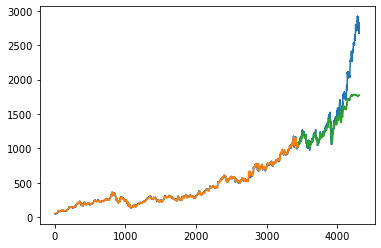

In [24]:
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2):len(dataset)-2, :] = test_pred

plt.plot(dataset)
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Multiple features

In [25]:
df = pd.read_csv("GOOG.csv", index_col='Date', parse_dates=True)
dataset = df.values.astype('float32')
tf.random.set_seed(10)

mm = MinMaxScaler(feature_range=(0,1))

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [26]:
train = mm.fit_transform(train)
test = mm.transform(test)

In [27]:
y_train = train[:,0]
y_test = test[:,0]

In [28]:
def create_dataset_features (dataset, look_back=1):
    dataX = np.ones(shape=(1, 6))
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), :]
        dataX = np.vstack((dataX, a))
    return np.array(dataX)

In [29]:
def create_test (dataset, look_back=1):
    dataY = np.ones(shape=(1))
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back)]
        dataY = np.vstack((dataY, a))
    return np.array(dataY)

In [30]:
look_back = 1
X_train = create_dataset_features(train, look_back)
X_test = create_dataset_features(test, look_back)
y_train = create_test(y_train, look_back)
y_test = create_test(y_test, look_back)

In [31]:
X_train = np.delete(X_train, 0, 0)
y_train = np.delete(y_train, 0, 0)
X_test = np.delete(X_test, 0, 0)
y_test = np.delete(y_test, 0, 0)

In [32]:
X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [34]:
model = Sequential()
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50, input_shape=(1, 6), return_sequences=True)))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(layers.LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.fit(X_train_reshape, y_train, epochs=100, batch_size = 64, verbose = 2)
model.summary()

Epoch 1/100
54/54 - 6s - loss: 0.0337 - 6s/epoch - 106ms/step
Epoch 2/100
54/54 - 0s - loss: 0.0015 - 151ms/epoch - 3ms/step
Epoch 3/100
54/54 - 0s - loss: 0.0012 - 139ms/epoch - 3ms/step
Epoch 4/100
54/54 - 0s - loss: 0.0012 - 150ms/epoch - 3ms/step
Epoch 5/100
54/54 - 0s - loss: 0.0010 - 152ms/epoch - 3ms/step
Epoch 6/100
54/54 - 0s - loss: 9.8681e-04 - 148ms/epoch - 3ms/step
Epoch 7/100
54/54 - 0s - loss: 9.1306e-04 - 140ms/epoch - 3ms/step
Epoch 8/100
54/54 - 0s - loss: 9.2544e-04 - 150ms/epoch - 3ms/step
Epoch 9/100
54/54 - 0s - loss: 8.4299e-04 - 140ms/epoch - 3ms/step
Epoch 10/100
54/54 - 0s - loss: 7.7612e-04 - 150ms/epoch - 3ms/step
Epoch 11/100
54/54 - 0s - loss: 7.6519e-04 - 140ms/epoch - 3ms/step
Epoch 12/100
54/54 - 0s - loss: 7.8274e-04 - 150ms/epoch - 3ms/step
Epoch 13/100
54/54 - 0s - loss: 6.8895e-04 - 140ms/epoch - 3ms/step
Epoch 14/100
54/54 - 0s - loss: 7.2872e-04 - 140ms/epoch - 3ms/step
Epoch 15/100
54/54 - 0s - loss: 6.2364e-04 - 150ms/epoch - 3ms/step
Epoch 16/1

In [35]:
# make predictions
train_pred = model.predict(X_train_reshape)
test_pred = model.predict(X_test_reshape)

# unable to inverse transform values due to original output having 6 features

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test score: %.2f RMSE" % (test_score))

27/27 [==============================] - 0s 1ms/step
Train score: 0.01 RMSE
Test score: 0.34 RMSE


In [36]:
dataset_trans = mm.transform(dataset)

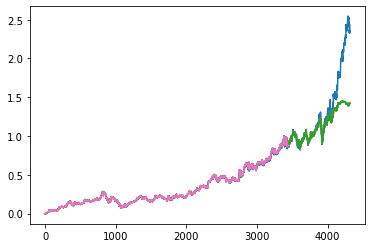

In [37]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(dataset_trans[:,0])
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()